# LD Tests #

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import leveldiagram as ld

## Basic 3-level diagrams ##

### Lambda ###

In [5]:
lambda_nodes = ((0),
                (1),
                (2, {'energy':-0.1}))
lambda_edges = ((0,1,{'detuning':0.1, 'label':'probe'}),
                (2,1,{'label':'couple', 'lw':4, 'arrowsize':0.2}))
lambda_graph = nx.DiGraph()
lambda_graph.add_nodes_from(lambda_nodes)
lambda_graph.add_edges_from(lambda_edges)

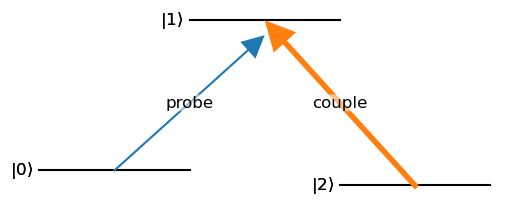

In [6]:
d = ld.LD(lambda_graph)
d.draw()
d.fig.savefig('lambda.png', bbox_inches='tight', dpi=150)

### Ladder ###

In [7]:
ladder_nodes = (0,1,2)
ladder_edges = ((0,1,{'label':'probe'}),
                (1,2,{'label':'couple'}))
ladder_graph = nx.DiGraph()
ladder_graph.add_nodes_from(ladder_nodes)
ladder_graph.add_edges_from(ladder_edges)

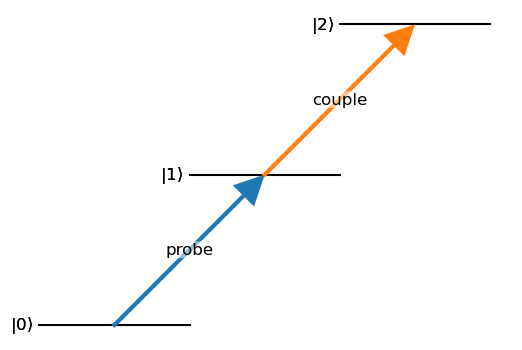

In [8]:
d = ld.LD(ladder_graph,
          coupling_defaults = {'arrowsize':0.2,'lw':3})
d.draw()

### Vee ###

In [9]:
v_nodes = ((0),
           (1,{'energy':1,'xpos':-1}),
           (2,{'energy':1, 'xpos':1}))
v_edges = ((0,1,{'label':'probe'}),
           (0,2,{'label':'couple'}))
v_graph = nx.DiGraph()
v_graph.add_nodes_from(v_nodes)
v_graph.add_edges_from(v_edges)

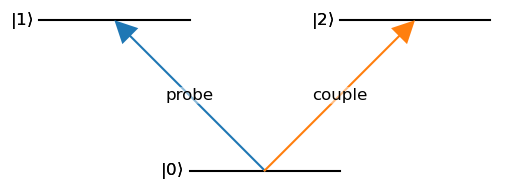

In [10]:
d = ld.LD(v_graph)
d.draw()

## Hyperfine Diagram ##

In [11]:
hf_nodes =  [((f,i), {('top' if f==2 else 'bottom') + '_text':'$m_F='+f'{i:d}'+'$',
                      'energy':f-1,
                      'xpos':i,
                      'width':0.75,
                      'text_kw':{'fontsize':'large'}})
             for f in [1,2]
             for i in range(-f,f+1)]
lin_couples = [((1,i),(2,i),{'label':l,'color':'C0',
                            'label_kw':{'fontsize':'medium','color':'C0'}})
               for i,l in zip(range(-1,2), ['1/2','2/3','1/2'])]
sp_couples = [((1,i),(2,i+1),{'label':l,'color':'C1',
                              'label_offset':'right',
                             'label_kw':{'fontsize':'medium','color':'C1'}})
              for i,l in zip(range(-1,2), ['1/6','1/2','1'])]
sm_couples = [((1,i),(2,i-1),{'label':l, 'color':'C2',
                              'label_offset':'left',
                             'label_kw':{'fontsize':'medium','color':'C2'}})
              for i,l in zip(range(-1,2), ['1','1/2','1/6'])]
hf_edges = lin_couples + sp_couples + sm_couples
hf_graph = nx.DiGraph()
hf_graph.add_nodes_from(hf_nodes)
hf_graph.add_edges_from(hf_edges)

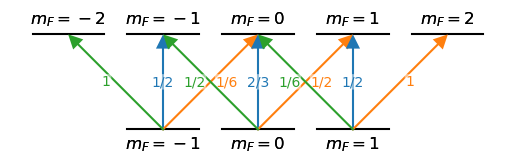

In [12]:
d = ld.LD(hf_graph, default_label = 'none')
d.ax.margins(y=0.2)
d.draw()
d.fig.savefig('hyperfine.png', bbox_inches='tight', dpi=150)

## 4-wave Mixing Diagram ##

In [13]:
fwm_nodes = ((0),
             (1,{'xpos':-1}),
             (2,{'xpos':1,'energy':1}),
             (3,{'energy':2,'xpos':0}))
fwm_edges = ((0,1),
             (1,3),
             (3,2),
             (2,0,{'label':'idler', 'wavy':True}))
fwm_graph = nx.DiGraph()
fwm_graph.add_nodes_from(fwm_nodes)
fwm_graph.add_edges_from(fwm_edges)

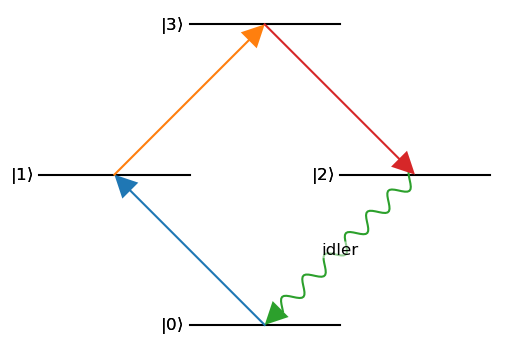

In [14]:
d = ld.LD(fwm_graph)
d.draw()

## Incorporation into a Larger Figure ##

In [15]:
bx_data = np.linspace(-10, 10, 51)
by_data = 3.2/(bx_data**2 + 2**2)

cx_data = np.linspace(0, 2*np.pi*10, 100)
cy_data = np.sin(cx_data)

Text(0, 0.5, 'Signal (arb.)')

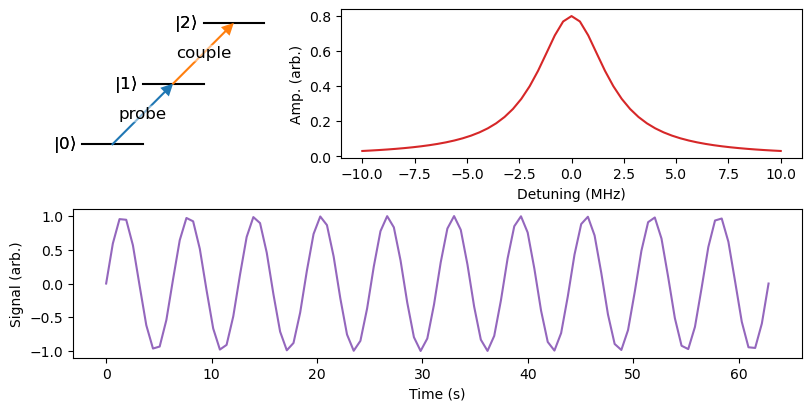

In [16]:
mosaic = [['a', 'b', 'b'],
          ['c', 'c', 'c']]

fig = plt.figure(figsize=(8,4), layout='constrained')
axs = fig.subplot_mosaic(mosaic)

### part a
d = ld.LD(ladder_graph, ax=axs['a'],
         coupling_defaults={'arrowsize':0.2})
d.draw()
axs['a'].set_aspect('equal')

### part b
axs['b'].plot(bx_data, by_data, color='C3')
axs['b'].set_xlabel('Detuning (MHz)')
axs['b'].set_ylabel('Amp. (arb.)')

### part c
axs['c'].plot(cx_data, cy_data, color='C4')
axs['c'].set_xlabel('Time (s)')
axs['c'].set_ylabel('Signal (arb.)')

## Draw graphs using other conventions ##

In [17]:
import rydiqule as rq

In [18]:
s = rq.Sensor(3)

probe = {'states':(0,1), 'rabi_frequency':1, 'detuning':0}
couple = {'states':(1,2), 'rabi_frequency':6, 'detuning': -1}

s.add_couplings(probe, couple)
s.add_decoherence((1,0), 6)
s.add_transit_broadening(0.1)

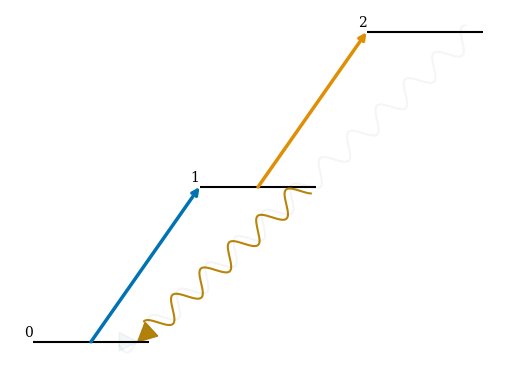

In [19]:
rq.draw_diagram(s)

In [20]:
def ryd_to_ld(sensor):

    rq_g = sensor.couplings.copy()
        
    # level settings
    if isinstance(sensor, rq.Cell):
        for lev, vals in rq_g.nodes.items():
            ld_kw = {}
            
    # coupling settings
    for edge, vals in rq_g.edges.items():
        ld_kw = {}
        if 'dipole_moment' in vals:
            ld_kw['linestyle'] = 'dashed'
        elif 'rabi_frequency' in vals:
            if not np.all(vals.get('rabi_frequency')):
                ld_kw['hidden'] = True
    
    # decoherence settings
    
    # get decoherence normalizations
    gamma_matrix = sensor.decoherence_matrix()
    # we get the biggest possible decoherence value for each term
    # by doing a max reduction along stack axes
    stack_axes = tuple(np.arange(0, gamma_matrix.ndim-2))
    gamma_matrix = gamma_matrix.max(axis=stack_axes)
    max_dephase = gamma_matrix.max()
    min_dephase = gamma_matrix[gamma_matrix != 0.0].min()
    if np.isclose(min_dephase, max_dephase):
        # all non-zero dephasings are the same, prevent /0 error in normalization
        min_dephase = max_dephase*1e-1

    # reversing order of traverse to prevent transit overlaps
    idxs = np.argwhere(gamma_matrix != 0.0)[::-1,:]
    for idx in idxs:

        ld_kw = {}

        ld_kw['wavy'] = True
        ld_kw['deflect'] = True
        ld_kw['start_anchor'] = 'right'
        if idx[0] == idx[1]:
            ld_kw['deflection'] = 0.15
        else:
            ld_kw['stop_anchor'] = (0.3, 0.0)
        # ensure alpha doesn't get too small to not be seen
        # also uses a log scale for the full range of non-zero dephasings
        alph = 1-(0.8*np.log10(gamma_matrix[tuple(idx)]/max_dephase
                               )/np.log10(min_dephase/max_dephase))
        ld_kw['alpha'] = alph

        rq_g.edges[tuple(idx)]['ld_kw'] = ld_kw
    
    return rq_g

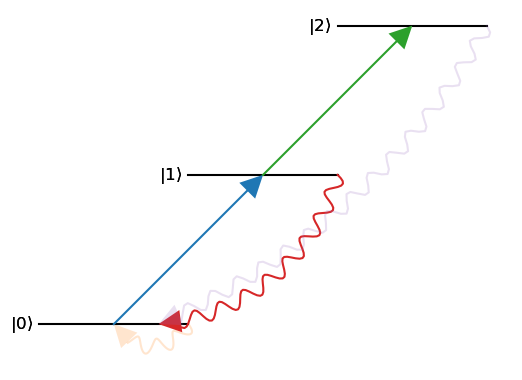

In [21]:
rq_g = ryd_to_ld(s)
d = ld.LD(rq_g, use_ld_kw=True)
d.draw()

In [22]:
ld.about()


        leveldiagram
    
leveldiagram Version: 0.2.0

        Dependencies
    
Python Version:       3.10.8
NumPy Version:        1.23.4
Matplotlib Version:   3.5.3
NetworkX Version:     2.8.4
